In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from keras.models import load_model
from PIL import Image
from keras.preprocessing import image
import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
root = 'C:\\Users\\mehme\\OneDrive\\Masaüstü\\Gender_CNN'

In [7]:
data = pd.read_csv("icml_face_data.csv")
data.shape


In [11]:
data.head()

,emotion,usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [12]:
data["usage"].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: usage, dtype: int64

In [14]:
np.unique(data["usage"].values.ravel())

print('Eğitim setindeki örnek sayısı: %d'%(len(data[data.usage == "Training"])))

Eğitim setindeki örnek sayısı: 28709


In [16]:
train_data = data [data.usage == "Training"]

In [17]:
train_pixels = train_data.pixels.str.split(" ").tolist() 

train_pixels = pd.DataFrame(train_pixels, dtype=int)
train_images = train_pixels.values
train_images = train_images.astype(np.float)

print(train_images)

print(train_images.shape)

[[ 70.  80.  82. ... 106. 109.  82.]
 [151. 150. 147. ... 193. 183. 184.]
 [231. 212. 156. ...  88. 110. 152.]
 ...
 [ 74.  81.  87. ... 188. 187. 187.]
 [222. 227. 203. ... 136. 136. 134.]
 [195. 199. 205. ...   6.  15.  38.]]
(28709, 2304)


<ipython-input-17-1eaf1e63132f>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_images = train_images.astype(np.float)


In [18]:
def show(img):
    show_image = img.reshape(48,48)
    
    plt.axis('off')
    plt.imshow(show_image, cmap='gray')

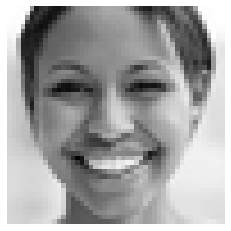

In [19]:
show(train_images[445])

In [20]:
train_labels_flat = train_data["emotion"].values.ravel()
train_labels_count = np.unique(train_labels_flat).shape[0]
print('Farklı yüz ifadelerinin sayısı: %d'%train_labels_count)

Farklı yüz ifadelerinin sayısı: 7


In [21]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [22]:
y_train = dense_to_one_hot(train_labels_flat, train_labels_count)

y_train = y_train.astype(np.uint8)

print(y_train.shape)

(28709, 7)


In [24]:
test_data = data[data.usage == "PublicTest"] 
test_pixels = test_data.pixels.str.split(" ").tolist() 

test_pixels = pd.DataFrame(test_pixels, dtype=int)
test_images = test_pixels.values
test_images = test_images.astype(np.float)

print(test_images.shape)

(3589, 2304)


<ipython-input-24-81c62cb06144>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_images = test_images.astype(np.float)


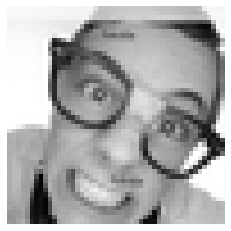

In [25]:
show(test_images[890])

In [26]:
test_labels_flat = test_data["emotion"].values.ravel()
test_labels_count = np.unique(test_labels_flat).shape[0]

y_test = dense_to_one_hot(test_labels_flat, test_labels_count)

y_test = y_test.astype(np.uint8)

print(y_test.shape)

(3589, 7)


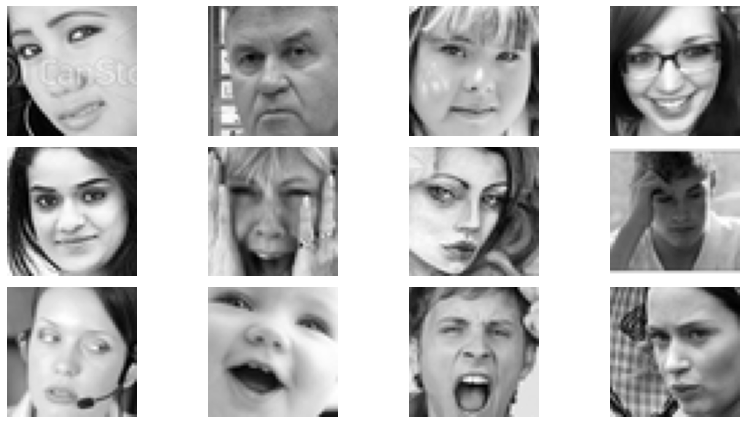

In [27]:
plt.figure(0, figsize=(12,6))
for i in range(1,13):
  plt.subplot(3, 4, i)
  plt.axis('off')

  image = test_images[i].reshape(48,48)
  plt.imshow(image, cmap='gray')

plt.tight_layout()
plt.show()

In [28]:
model = Sequential()

#1. KATMAN
model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal", input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

#2. KATMAN

model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.6)) #%60 unutma işlemi(nöron silme-dropout)

### 3. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))


### 4. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))

### 5. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.6)) #%60 unutma işlemi(nöron silme-dropout)

### TAM BAĞLANTI KATMANI
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))#%60 unutma işlemi(nöron silme-dropout)

### Çıkış katmanı

model.add(Dense(7))
model.add(Activation('softmax')) #Sınıflama işlemi (7 duygu sınıfı var)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #opmizasyon ve başarım hesaplama metriklerinin belirlenmesi
#model özetini görselleştirelim

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 44, 44, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 44, 44, 64)        0

In [29]:
x_train = train_images.reshape(-1, 48, 48, 1)
x_test = test_images.reshape(-1, 48, 48, 1)

print('Train:', x_train.shape)
print('Test:', x_test.shape)

Train: (28709, 48, 48, 1)
Test: (3589, 48, 48, 1)


In [32]:
# en başarılı ağırlıkları kaydet
checkpointer = ModelCheckpoint(filepath=root + '\\facee_model.h5', verbose=1, save_best_only=True)

epochs = 10
batchSize = 100

# modeli çalıştır

hist = model.fit(x_train, y_train,
                 epochs=epochs,
                 shuffle=True,
                 batch_size=batchSize,
                 validation_data=(x_test, y_test),
                 callbacks=[checkpointer], verbose=2)
                
# save model to json
model_json = model.to_json()
with open(root +'\\face_model.json', 'w') as json_file:
  json_file.write(model_json)

Epoch 1/10

Epoch 00001: val_loss improved from inf to 1.59897, saving model to C:\Users\mehme\OneDrive\Masaüstü\Gender_CNN\facee_model.h5
288/288 - 251s - loss: 1.9910 - accuracy: 0.2551 - val_loss: 1.5990 - val_accuracy: 0.3901 - 251s/epoch - 873ms/step
Epoch 2/10

Epoch 00002: val_loss improved from 1.59897 to 1.49372, saving model to C:\Users\mehme\OneDrive\Masaüstü\Gender_CNN\facee_model.h5
288/288 - 263s - loss: 1.6382 - accuracy: 0.3598 - val_loss: 1.4937 - val_accuracy: 0.4193 - 263s/epoch - 914ms/step
Epoch 3/10

Epoch 00003: val_loss improved from 1.49372 to 1.44013, saving model to C:\Users\mehme\OneDrive\Masaüstü\Gender_CNN\facee_model.h5
288/288 - 264s - loss: 1.5265 - accuracy: 0.4041 - val_loss: 1.4401 - val_accuracy: 0.4369 - 264s/epoch - 915ms/step
Epoch 4/10

Epoch 00004: val_loss improved from 1.44013 to 1.43958, saving model to C:\Users\mehme\OneDrive\Masaüstü\Gender_CNN\facee_model.h5
288/288 - 274s - loss: 1.4537 - accuracy: 0.4400 - val_loss: 1.4396 - val_accurac

In [2]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Eğitim', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color ='r', label='Training Loss')
plt.plot(hist.history['val_loss'], color ='b', label='Validation Loss')
plt.legend(loc='upper right')


plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color ='g', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color ='m', label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()

NameError: name 'plt' is not defined

In [35]:
test = data[["emotion", "pixels"]][data["usage"] == "PrivateTest"]
test["pixels"] = test["pixels"].apply(lambda im: np.fromstring(im, sep=' '))

test.head()

,emotion,pixels
32298,0,"[170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, ..."
32299,5,"[7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, ..."
32300,6,"[232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246..."
32301,4,"[200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111...."
32302,2,"[40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78...."


In [36]:
x_test_private = np.vstack(test["pixels"].values)
y_test_private = np.array(test["emotion"])

In [37]:
x_test_private = x_test_private.reshape(-1, 48, 48, 1)
y_test_private = np_utils.to_categorical(y_test_private)
x_test_private.shape, y_test_private.shape

((3589, 48, 48, 1), (3589, 7))

In [38]:
score = model.evaluate(x_test_private, y_test_private, verbose=0)
print("PrivateTest üzerindeki doğruluk durumu:", score)

PrivateTest üzerindeki doğruluk durumu: [1.2395399808883667, 0.5090554356575012]


In [3]:
# en iyi ağırlıkları yükle
model_best = load_model('./facee_model.h5')

In [6]:
image_path ="./images/uzgun_kenan.jpg"

test_image_original = image.load_img(image_path) # orjinal renkli görüntü

test_image = image.load_img(image_path, target_size=(48, 48), grayscale=True)
test_data = image.img_to_array(test_image)

test_data = np.expand_dims(test_data, axis=0)
test_data = np.vstack([test_data])

results = model_best.predict(test_data, batch_size=1)
results

C:\Users\Emre\AppData\Local\Programs\Python\Python38\lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


array([[0.20163618, 0.00540017, 0.20563091, 0.01023076, 0.34719685,
        0.03575558, 0.19414955]], dtype=float32)

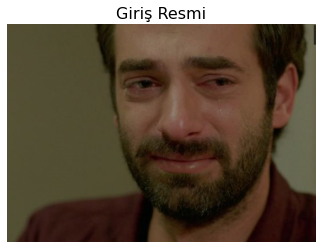

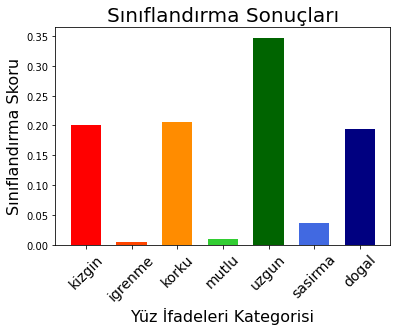

Sınıflandırma sonucu en yüksek oranla: uzgun


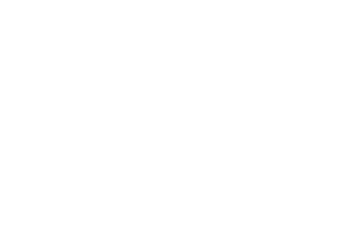

In [7]:
#sınıflarımız 7 adet duygu durumumuz
class_names = ['kizgin', 'igrenme', 'korku', 'mutlu', 'uzgun', 'sasirma', 'dogal']

ind = 0.1+0.6*np.arange(len(class_names))
width = 0.4  #bar genişliği

color_list = ['red','orangered','darkorange','limegreen','darkgreen','royalblue','navy']

# test resmimizi çizdirelim

plt.imshow(test_image_original)
plt.title('Giriş Resmi', fontsize=16)
plt.axis('off')
plt.show()

#sonuçlarımızı renklendirelim

for i in range(len(class_names)):
  plt.bar(ind[i], results[0][i], width, color=color_list[i])

plt.title("Sınıflandırma Sonuçları", fontsize=20)
plt.xlabel("Yüz İfadeleri Kategorisi",fontsize=16)
plt.ylabel("Sınıflandırma Skoru",fontsize=16)
plt.xticks(ind, class_names, rotation=45, fontsize=14)
plt.show()


print("Sınıflandırma sonucu en yüksek oranla:", class_names[np.argmax(results)])

# en yüksek skorlu duyguya karşılık emoji çizdirelim




plt.axis('off')
plt.show()